In [1]:
import tensorflow as tf
import numpy as np
from gbica_utils import *
from tf_powersfa import *
from tensorflow.keras.layers import *
from tensorflow.nn import *

In [2]:
n_out = 3

In [3]:
N = 1000

encoding_x = tf.placeholder("float", [N, n_out])
with tf.name_scope("encoder"):
    dense0 = tf.keras.layers.Dense(n_out)(encoding_x)
encoder_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder')

dense = alt_power_whitening(dense0, n_out, 50)[0]

In [4]:
n_hidden = 64

y1, y2, y3 = tf.split(dense, 3, axis=1)

In [5]:
x1 = tf.concat([y2, y3], axis=1)
y_1 = permute_y(y1, N)
x2 = tf.concat([y1, y3], axis=1)
y_2 = permute_y(y2, N)
x3 = tf.concat([y1, y2], axis=1)
y_3 = permute_y(y3, N)
h_join1 = tf.concat([y1, x1], axis=1)
h_marg1 = tf.concat([y_1, x1], axis=1)
h_join2 = tf.concat([y2, x2], axis=1)
h_marg2 = tf.concat([y_2, x2], axis=1)
h_join3 = tf.concat([y3, x3], axis=1)
h_marg3 = tf.concat([y_3, x3], axis=1)
with tf.name_scope("estimator"):
    initial_bias = tf.keras.initializers.Constant(value=0.1)
    estimator1 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator2 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator3 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator4 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator5 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator6 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator7 = Dense(n_hidden, bias_initializer=initial_bias)
    
    def estimator_net_merge(h_join, h_marg, estimator): 
        dense1_joint = leaky_relu(estimator[0](h_join))
        dense2_joint = leaky_relu(estimator[1](dense1_joint))
        dense3_joint = leaky_relu(estimator[2](dense2_joint))
        dense4_joint = leaky_relu(estimator[3](dense3_joint))
        dense5_joint = leaky_relu(estimator[4](dense4_joint))
        dense6_joint = leaky_relu(estimator[5](dense5_joint))
        dense7_joint = estimator[6](dense6_joint)

        dense1_marg = leaky_relu(estimator[0](h_marg))
        dense2_marg = leaky_relu(estimator[1](dense1_marg))
        dense3_marg = leaky_relu(estimator[2](dense2_marg))
        dense4_marg = leaky_relu(estimator[3](dense3_marg))
        dense5_marg = leaky_relu(estimator[4](dense4_marg))
        dense6_marg = leaky_relu(estimator[5](dense5_marg))
        dense7_marg = estimator[6](dense6_marg)
        return dense7_joint, dense7_marg
    
    dense7_joint, dense7_marg = estimator_net_merge(h_join1, h_marg1, [estimator1, estimator2,
                                                estimator3, estimator4, estimator5, estimator6, estimator7])
    dense7_joint2, dense7_marg2 = estimator_net_merge(h_join2, h_marg2, [estimator1, estimator2,
                                                estimator3, estimator4, estimator5, estimator6, estimator7])
    dense7_joint3, dense7_marg3 = estimator_net_merge(h_join3, h_marg3, [estimator1, estimator2,
                                                estimator3, estimator4, estimator5, estimator6, estimator7])

estimator_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='estimator')

loss1 = tf.reduce_mean(dense7_joint)-tf.log(tf.reduce_mean(tf.exp(dense7_marg)))
loss2 = tf.reduce_mean(dense7_joint2)-tf.log(tf.reduce_mean(tf.exp(dense7_marg2)))
loss3 = tf.reduce_mean(dense7_joint3)-tf.log(tf.reduce_mean(tf.exp(dense7_marg3)))

In [6]:
estimator_loss = -(loss1+loss2+loss3)

total_encoder_loss = loss1+loss2+loss3
encoder_lr = 0.005

train_encoders = tf.train.AdamOptimizer(encoder_lr).minimize(total_encoder_loss, var_list=encoder_var_list)

regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)

for var in estimator_var_list:
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, var)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
estimator_loss += reg_term
train_estimators =  tf.contrib.opt.NadamOptimizer(0.005).minimize(estimator_loss, var_list=estimator_var_list) 

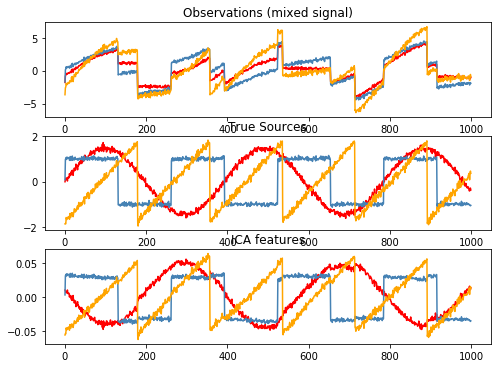

In [7]:
%matplotlib inline

X, ica, S, S_ = bss3_experiment(N)

models = [X, S, S_]
names = ['Observations (mixed signal)', 'True Sources', 'ICA features']
colors = ['red', 'steelblue', "orange"]
plt.figure(figsize=(8, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

step: 0, loss1: -0.021, loss2: -0.022, loss3: -0.022, all_loss: -0.064


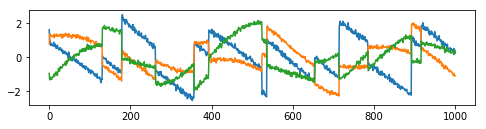

step: 100, loss1: 0.36, loss2: 0.34, loss3: 0.35, all_loss: 1.0
step: 200, loss1: 0.51, loss2: 0.57, loss3: 0.45, all_loss: 1.5
step: 300, loss1: 0.55, loss2: 0.61, loss3: 0.57, all_loss: 1.7
step: 400, loss1: 0.43, loss2: 0.4, loss3: 0.47, all_loss: 1.3


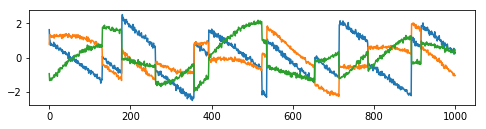

step: 500, loss1: 0.7, loss2: 0.71, loss3: 0.63, all_loss: 2.0
step: 600, loss1: 0.88, loss2: 0.8, loss3: 0.93, all_loss: 2.6
step: 700, loss1: 0.94, loss2: 0.9, loss3: 0.76, all_loss: 2.6
step: 800, loss1: 0.65, loss2: 0.51, loss3: 0.47, all_loss: 1.6


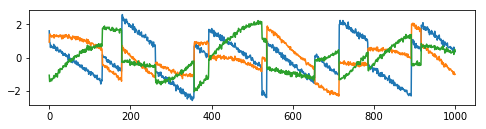

step: 900, loss1: 0.59, loss2: 0.36, loss3: 0.63, all_loss: 1.6
step: 1000, loss1: 1.1, loss2: 0.87, loss3: 1.0, all_loss: 3.0
step: 1100, loss1: 0.63, loss2: 0.61, loss3: 0.64, all_loss: 1.9
step: 1200, loss1: 0.39, loss2: 0.28, loss3: 0.55, all_loss: 1.2


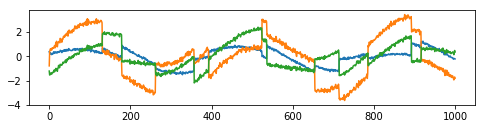

step: 1300, loss1: 0.83, loss2: 0.89, loss3: 0.91, all_loss: 2.6
step: 1400, loss1: 1.0, loss2: 1.2, loss3: 1.1, all_loss: 3.3
step: 1500, loss1: 1.3, loss2: 1.2, loss3: 1.3, all_loss: 3.8
step: 1600, loss1: 1.4, loss2: 1.3, loss3: 1.3, all_loss: 4.0


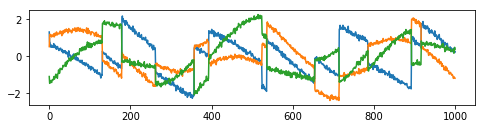

step: 1700, loss1: 1.6, loss2: 1.5, loss3: 1.5, all_loss: 4.6
step: 1800, loss1: 1.4, loss2: 1.2, loss3: 1.0, all_loss: 3.6
step: 1900, loss1: 1.2, loss2: 1.1, loss3: 0.85, all_loss: 3.2
step: 2000, loss1: 0.7, loss2: 0.61, loss3: 0.26, all_loss: 1.6


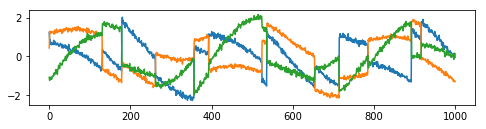

step: 2100, loss1: 1.1, loss2: 1.2, loss3: 0.92, all_loss: 3.3
step: 2200, loss1: 1.0, loss2: 0.96, loss3: 0.57, all_loss: 2.6
step: 2300, loss1: 0.68, loss2: 0.42, loss3: 0.43, all_loss: 1.5
step: 2400, loss1: 0.32, loss2: 0.38, loss3: 0.48, all_loss: 1.2


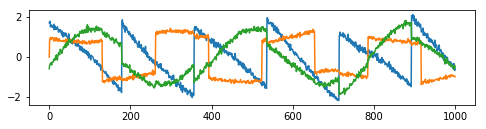

step: 2500, loss1: 0.77, loss2: 0.82, loss3: 0.69, all_loss: 2.3
step: 2600, loss1: 1.1, loss2: 1.1, loss3: 0.92, all_loss: 3.2
step: 2700, loss1: 1.0, loss2: 0.88, loss3: 0.69, all_loss: 2.6
step: 2800, loss1: 1.2, loss2: 1.2, loss3: 0.98, all_loss: 3.4


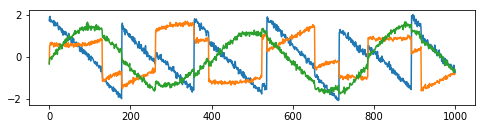

step: 2900, loss1: 0.91, loss2: 0.85, loss3: 0.84, all_loss: 2.6
step: 3000, loss1: 1.3, loss2: 1.3, loss3: 1.0, all_loss: 3.6
step: 3100, loss1: 0.72, loss2: 0.65, loss3: 0.54, all_loss: 1.9
step: 3200, loss1: 0.56, loss2: 0.51, loss3: 0.76, all_loss: 1.8


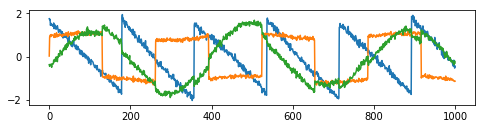

step: 3300, loss1: 0.74, loss2: 0.73, loss3: 1.0, all_loss: 2.5
step: 3400, loss1: 1.1, loss2: 1.2, loss3: 1.2, all_loss: 3.5
step: 3500, loss1: 1.1, loss2: 1.0, loss3: 1.1, all_loss: 3.2
step: 3600, loss1: 0.78, loss2: 0.37, loss3: 0.52, all_loss: 1.7


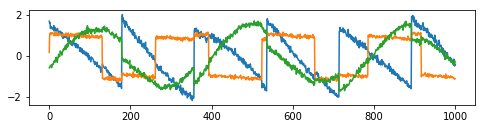

step: 3700, loss1: 0.63, loss2: 0.34, loss3: 0.54, all_loss: 1.5
step: 3800, loss1: 1.1, loss2: 0.86, loss3: 0.88, all_loss: 2.9
step: 3900, loss1: 0.53, loss2: 0.24, loss3: 0.58, all_loss: 1.3
step: 4000, loss1: 0.68, loss2: 0.29, loss3: 0.61, all_loss: 1.6


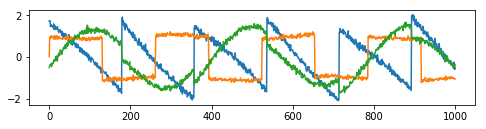

In [8]:
from random import shuffle
shuffled_x = np.array(X)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(4001):
        np.random.shuffle(shuffled_x)
        current_loss1, current_loss2, current_loss3, _ = sess.run([loss1,
                                                    loss2, loss3, train_estimators], feed_dict={encoding_x:X})

        if i % 7   is 0: 
            _ = sess.run(train_encoders, feed_dict={encoding_x:X})

        if i % 100 is 0: 
            print("step: {}, loss1: {:.2}, loss2: {:.2}, loss3: {:.2}, all_loss: {:.2}".format(i,
                                current_loss1, current_loss2, current_loss3, current_loss1+current_loss2+current_loss3))
        if i % 400 is 0:
            plt.figure(figsize=(8, 8))
            plt.subplot(4, 1, 1)
            encoding = sess.run(dense, feed_dict={encoding_x:X})
            plt.plot(encoding)
            plt.show()